In [1]:
import numpy as np
import benchmark_functions as bf

In [2]:
# Thuật toán Tiến hóa vi phân
class DifferentialEvolution:
    def __init__(
        self, 
        objective_function, 
        dimensions, 
        bounds, 
        population_size, 
        mutation_factor, 
        crossover_probability, 
        generations,
        counter = None
    ):
        
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.bounds = bounds
        self.population_size = population_size
        self.mutation_factor = mutation_factor
        self.crossover_probability = crossover_probability
        self.generations = generations
        self.counter = counter
        
        self.best_solution = None
        self.best_value = float('inf')
        self.history = []  # Lưu giá trị tốt nhất của mỗi thế hệ
        self.population = None

    # Khởi tạo quần thể
    def initialize_population(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimensions))

    # Hàm đột biến
    def mutate(self, population, idx):
        indices = [i for i in range(self.population_size) if i != idx]
        a, b, c = np.random.choice(indices, 3, replace=False)
        mutant_vector = np.clip(population[a] + self.mutation_factor * (population[b] - population[c]), self.bounds[0], self.bounds[1])
        return mutant_vector

    # Hàm lai ghép
    def crossover(self, target_vector, mutant_vector):
        crossover_mask = np.random.rand(self.dimensions) < self.crossover_probability
        trial_vector = np.where(crossover_mask, mutant_vector, target_vector)
        return trial_vector
    
    # Hàm chọn lọc
    def select(self, population, trial_vector, idx):
        if self.objective_function.evaluate(trial_vector) < self.objective_function.evaluate(population[idx]):
            population[idx] = trial_vector
            value = self.objective_function.evaluate(population[idx])
            if value < self.best_value:
                self.best_value = value
                self.best_solution = population[idx]

    # Hàm thực thi
    def run(self):
        self.population = self.initialize_population()
        no_improvement_counter = 0
        
        for generation in range(self.generations):
            for idx in range(self.population_size):
                mutant_vector = self.mutate(self.population, idx)
                trial_vector = self.crossover(self.population[idx], mutant_vector)
                self.select(self.population, trial_vector, idx)
            self.history.append(self.best_value)
            
            if generation > 0 and generation % 1000 == 0:
                print(f'Best value in generation {generation}: {self.best_value}')
            
            # Kiểm tra xem có cải thiện hay không
            if len(self.history) > 1 and self.history[-1] < self.history[-2]:
                no_improvement_counter = 0 # Đặt lại bộ đếm nếu có cải thiện
            else:
                no_improvement_counter += 1 # Tăng bộ đếm nếu không có cải thiện

            if self.counter is not None and no_improvement_counter >= self.counter:
                break  
            
        return self.best_solution, self.best_value

In [3]:
# Tạo một thực thể của giải thuật DE với các tham số cụ thể
de = DifferentialEvolution(
    objective_function = bf.RosenbrocksFunction(20),  # Chọn một hàm từ danh sách hàm đã tạo trước đó
    dimensions = 20, # Số chiều
    bounds = (-10, 10),  # Giới hạn của không gian tìm kiếm
    population_size = 40,  # Kích thước quần thể
    mutation_factor = 0.6,  # Hệ số đột biến
    crossover_probability = 0.9,  # Xác suất lai ghép
    generations = 6000,  # Số thế hệ
    counter = 100 # Bộ đếm số thế hệ không cải thiện 
)

# Chạy giải thuật
best_solution, best_value = de.run()

Best value in generation 1000: 8.302382059544566
Best value in generation 2000: 0.0998329923152691
Best value in generation 3000: 9.599193278579073e-10
Best value in generation 4000: 1.0201848164812538e-18
Best value in generation 5000: 1.2303764931118969e-28


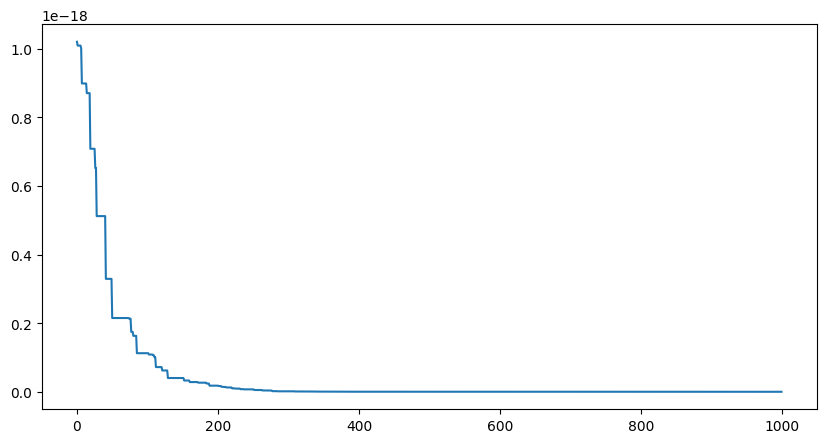

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(de.history[4000:5000])
plt.show()

In [5]:
class JADE:
    def __init__(
        self, 
        objective_function, 
        dimension, 
        bounds,
        population_size, 
        max_generations, 
        f_min = 0.1, 
        f_max = 1, 
        cr_min = 0, 
        cr_max = 1, 
        p = 0.1
    ):
        self.objective_function = objective_function
        self.dimension = dimension
        self.bounds = bounds
        self.population_size = population_size
        self.max_generations = max_generations
        self.f_min = f_min
        self.f_max = f_max
        self.cr_min = cr_min
        self.cr_max = cr_max
        self.p = p

        self.population = self.initialize_population()
        self.fitness = [self.objective_function.evaluate(x) for x in self.population]
        self.mu_cr = 0.5
        self.mu_f = 0.5
        self.archive = []

    def initialize_population(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimension))

    def mutate(self, target_idx):
        p_best_size = max(int(self.population_size * self.p), 2)
        p_best = self.population[np.argsort(self.fitness)[:p_best_size]]
        x_p_best = p_best[np.random.randint(len(p_best))]

        candidates = np.arange(self.population_size)
        candidates = np.delete(candidates, target_idx)
        x_r1 = self.population[np.random.choice(candidates)]

        if len(self.archive) > 0:
            x_r2 = self.archive[np.random.randint(len(self.archive))]
        else:
            x_r2 = self.population[np.random.choice(candidates)]

        f = np.clip(np.random.normal(self.mu_f, 0.1), self.f_min, self.f_max)
        return x_p_best + f * (x_r1 - x_r2), f

    def crossover(self, target, mutant, cr):
        j_rand = np.random.randint(self.dimension)
        cross_points = np.random.rand(self.dimension) < cr
        cross_points[j_rand] = True  # Ensure at least one dimension is from the mutant
        return np.where(cross_points, mutant, target)

    def evolve(self):
        best_fitness_history = []
        successful_f = []
        successful_cr = []

        for _ in range(self.max_generations):
            for i in range(self.population_size):
                cr = np.clip(np.random.normal(self.mu_cr, 0.1), self.cr_min, self.cr_max)
                mutant, f = self.mutate(i)
                trial = self.crossover(self.population[i], mutant, cr)
                trial_fitness = self.objective_function.evaluate(trial)

                if trial_fitness < self.fitness[i]:
                    self.archive.append(self.population[i])
                    self.population[i] = trial
                    self.fitness[i] = trial_fitness
                    successful_f.append(f)
                    successful_cr.append(cr)

            if successful_f and successful_cr:
                self.mu_f = (1 - 0.1) * self.mu_f + 0.1 * np.mean(np.square(successful_f)) / np.mean(successful_f)
                self.mu_cr = (1 - 0.1) * self.mu_cr + 0.1 * np.mean(successful_cr)

            best_idx = np.argmin(self.fitness)
            best_fitness_history.append(self.fitness[best_idx])

            # Giới hạn lưu trữ
            if len(self.archive) > self.population_size:
                random_indices = np.random.choice(len(self.archive), self.population_size, replace=False)
                self.archive = [self.archive[i] for i in random_indices]
                
        best_index = np.argmin(self.fitness)
        best_solution = self.population[best_index]
        best_fitness = self.fitness[best_index]
        return best_solution, best_fitness, best_fitness_history


In [6]:
jade = JADE(
    objective_function = bf.RosenbrocksFunction(20),
    dimension = 20, 
    bounds = (-10, 10),
    population_size = 40, 
    max_generations = 5000,
    f_min = 0.1, 
    f_max = 0.9, 
    cr_min = 0, 
    cr_max = 1, 
    p = 0.2
)

best_solution, best_fitness, best_fitness_history = jade.evolve()

In [7]:
best_fitness

0.08320423249741808

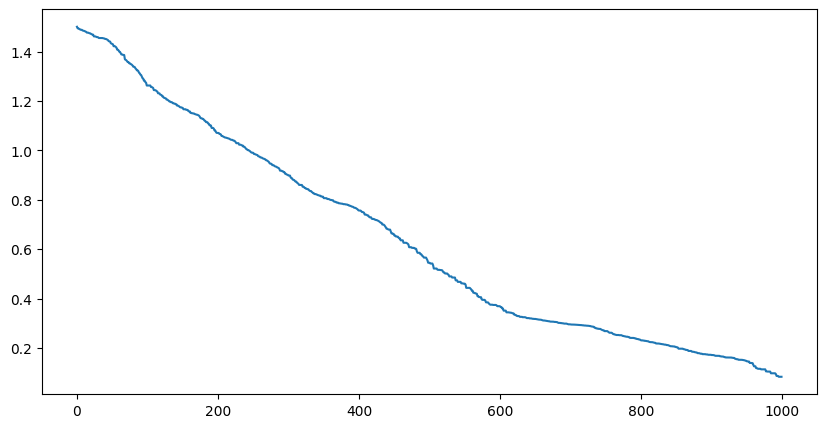

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(best_fitness_history[4000:5000])
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, dimensions):
        super(DenoisingAutoencoder, self).__init__()
        # Định nghĩa lớp mã hóa và giải mã
        
        # Lớp mã hóa
        self.encoder = nn.Sequential(
            nn.Linear(dimensions, dimensions//2), # Giảm chiều
            nn.ReLU(True),
            nn.Linear(dimensions//2, dimensions//4),
            nn.ReLU(True)
        )
        
        # Lớp giải mã
        self.decoder = nn.Sequential(
            nn.Linear(dimensions//4, dimensions//2),
            nn.ReLU(True),
            nn.Linear(dimensions//2, dimensions),
            nn.ReLU()
        )

    def forward(self, x):
        # Thêm nhiễu Gaussian
        x_noisy = x + torch.randn_like(x) * 0.1
        x_noisy = torch.clamp(x_noisy, -10, 10)  # Đảm bảo rằng dữ liệu vẫn nằm trong khoảng hợp lệ
        encoded = self.encoder(x_noisy)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
model = DenoisingAutoencoder(20)
model.eval()

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=5, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
  )
)

In [12]:
class ExplicitGeneticTransfer:
    def __init__(
        self, 
        objective_function1, 
        objective_function2, 
        dimensions, 
        bounds, 
        population_size, 
        mutation_factor, 
        crossover_probability, 
        generations,
        transfer_generations
    ):
        self.de1 = DifferentialEvolution(
            objective_function1, 
            dimensions, 
            bounds = bounds[0], 
            population_size = population_size[0], 
            mutation_factor = mutation_factor[0], 
            crossover_probability = crossover_probability[0], 
            generations = generations
        )
        self.de2 = DifferentialEvolution(
            objective_function2, 
            dimensions, 
            bounds = bounds[1], 
            population_size = population_size[1], 
            mutation_factor = mutation_factor[1], 
            crossover_probability = crossover_probability[1], 
            generations = generations
        )
        
        self.dae = DenoisingAutoencoder(dimensions)
        self.optimizer = optim.Adam(self.dae.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        
        self.history1 = []
        self.history2 = []
        self.transfer_generations = transfer_generations

    def train_dae(self, data_in, data_out, epochs=5000):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            reconstructions = self.dae(data_in)
            loss = self.criterion(reconstructions, data_out)
            loss.backward()
            self.optimizer.step()

    def transfer_solutions(self, population1, population2):
        population_size = len(population2)
        
        # Lấy 10 lời giải tốt nhất từ quần thể 1
        transfer_indices = np.argsort([self.de1.objective_function.evaluate(x) for x in population1])[:10]
        transferred_solutions = population1[transfer_indices]

        # Chuyển đổi thành tensor PyTorch
        transferred_solutions_tensor = torch.tensor(transferred_solutions, dtype=torch.float32)
    
        # Bổ sung vào quần thể 2 thông qua mô hình DAE
        dae_output = self.dae(transferred_solutions_tensor).detach().numpy()
        population2 = np.vstack((population2, dae_output))

        # Sắp xếp lại quần thể 2 và giữ lại số lượng cá thể là population_size
        fitness_values = np.array([self.de2.objective_function.evaluate(x) for x in population2])
        sorted_indices = np.argsort(fitness_values)
        population2 = population2[sorted_indices[:population_size]]

    def evolve(self):
        # Chạy DE cho từng hàm
        self.de1.run()
        self.de2.run()

        # Lấy mẫu và huấn luyện DAE sau khi chạy DE 1000 thế hệ
        sample_size = 30
        selected_indices1 = np.random.choice(len(self.de1.population), sample_size, replace=False)
        selected_indices2 = np.random.choice(len(self.de2.population), sample_size, replace=False)
        data_in1 = torch.tensor(self.de1.population[selected_indices1], dtype=torch.float32)
        data_out2 = torch.tensor(self.de2.population[selected_indices2], dtype=torch.float32)

        # Huấn luyện DAE
        self.train_dae(data_in1, data_out2)

        # Tiếp tục chạy DE và thực hiện MFEA step
        for generation in range(self.transfer_generations):
            if generation % 100 == 0 and generation > 0:
                self.transfer_solutions(self.de1.population, self.de2.population)
                
            for idx in range(self.de1.population_size):
                # Chạy DE cho bài toán 1
                mutant_vector1 = self.de1.mutate(self.de1.population, idx)
                trial_vector1 = self.de1.crossover(self.de1.population[idx], mutant_vector1)
                self.de1.select(self.de1.population, trial_vector1, idx)
                
                # Chạy DE cho bài toán 2
                mutant_vector2 = self.de2.mutate(self.de2.population, idx)
                trial_vector2 = self.de2.crossover(self.de2.population[idx], mutant_vector2)
                self.de2.select(self.de2.population, trial_vector2, idx)
                
            self.history1.append(self.de1.best_value)
            self.history2.append(self.de2.best_value)
            
        return self.history1, self.history2

In [13]:
egt_algorithm = ExplicitGeneticTransfer(
    objective_function1 = bf.SchaffersF7Function(20), 
    objective_function2 = bf.HappyCatFunction(20), 
    dimensions = 20, 
    bounds = [(-30, 30), (-20, 20)], 
    population_size = (40, 50), 
    mutation_factor = (0.6, 0.7), 
    crossover_probability = (0.9, 0.9), 
    generations = 5000,
    transfer_generations = 5000
)

egt_algorithm.evolve()
best_solution1, best_value1 = egt_algorithm.de1.best_solution, egt_algorithm.de1.best_value
best_solution2, best_value2 = egt_algorithm.de2.best_solution, egt_algorithm.de2.best_value

Best value in generation 1000: 0.0002956287493807664
Best value in generation 2000: 1.2887826246599698e-09
Best value in generation 3000: 4.232122431620781e-18
Best value in generation 4000: 1.633968088770012e-26
Best value in generation 1000: 0.2854079957279627
Best value in generation 2000: 0.2854079957279627
Best value in generation 3000: 0.2854079957279627
Best value in generation 4000: 0.2854079957279627


In [14]:
best_value1

5.547999495692583e-73

In [15]:
best_value2

0.28060134832409017

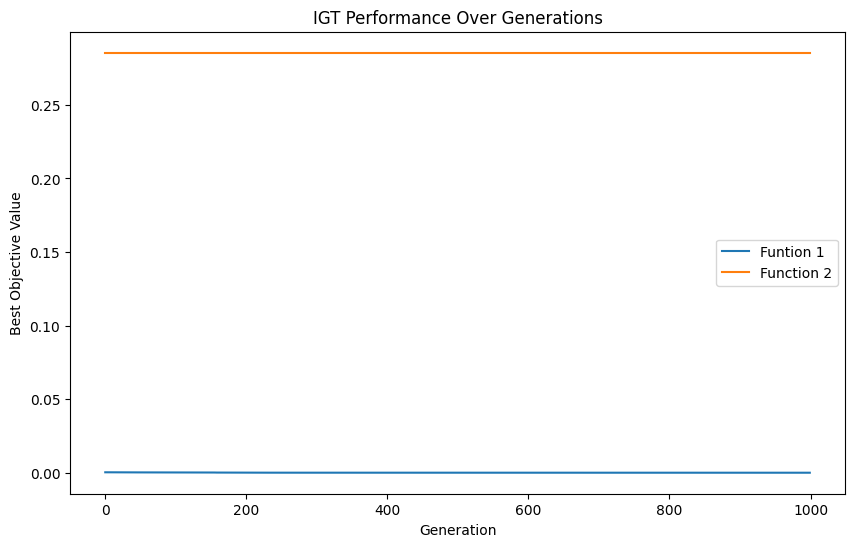

In [16]:
func1_values = egt_algorithm.de1.history + egt_algorithm.history1
func2_values = egt_algorithm.de2.history + egt_algorithm.history2

# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(func1_values[1000:2000], label='Funtion 1')
plt.plot(func2_values[1000:2000], label='Function 2')
plt.title('IGT Performance Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Objective Value')
plt.legend()
plt.show()